In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

data = pd.read_csv(r"C:\Users\Admin\Desktop\DATA EXERCISES\Data Cleaning\515K Hotel Reviews Dataset\Old_Data\Hotel_Reviews.csv", engine="python")

print("Initial Data Info Check:")
print(data.shape)
print("Duplicates Before Cleaning: ", data.duplicated().sum())
print("Missing Before Cleaning: ", data.isna().sum())

Initial Data Info Check:
(515738, 17)
Duplicates Before Cleaning:  526
Missing Before Cleaning:  Hotel_Address                                    0
Additional_Number_of_Scoring                     0
Review_Date                                      0
Average_Score                                    0
Hotel_Name                                       0
Reviewer_Nationality                             0
Negative_Review                                  0
Review_Total_Negative_Word_Counts                0
Total_Number_of_Reviews                          0
Positive_Review                                  0
Review_Total_Positive_Word_Counts                0
Total_Number_of_Reviews_Reviewer_Has_Given       0
Reviewer_Score                                   0
Tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
dtype: int64


Dropping lat, lng, and Hotel Address since we're not doing any geography-based analysis. Also dropping total negative and positive word counts since it is not significant in analysis. We will create a new column for days since review with int() dtype and up to date values. 

In [2]:
data = data.drop_duplicates()

drop_cols = ["days_since_review", "lat", "lng", "Hotel_Address", "Review_Total_Negative_Word_Counts", "Review_Total_Positive_Word_Counts"]

data = data.drop(columns=[cols for cols in drop_cols if cols in data.columns], errors="ignore")
data['Review_Date'] = pd.to_datetime(data['Review_Date'], format="%m/%d/%Y")
today = pd.Timestamp.today()
data["Days_Since_Review"] = (today - data["Review_Date"]).dt.days

data["Hotel_Name"] = data["Hotel_Name"].astype("category")
data["Reviewer_Nationality"] = data["Reviewer_Nationality"].astype("category")

print(data.dtypes)
print(data.shape)

Additional_Number_of_Scoring                           int64
Review_Date                                   datetime64[ns]
Average_Score                                        float64
Hotel_Name                                          category
Reviewer_Nationality                                category
Negative_Review                                       object
Total_Number_of_Reviews                                int64
Positive_Review                                       object
Total_Number_of_Reviews_Reviewer_Has_Given             int64
Reviewer_Score                                       float64
Tags                                                  object
Days_Since_Review                                      int64
dtype: object
(515212, 12)


Combining positive and negative reviews into one column

In [3]:
data["Review"] = data["Positive_Review"] + ' ' + data["Negative_Review"]
data["Review"] = data["Review"].str.lower()
data["Review"] = data["Review"].str.strip()
data["Review"] = data["Review"].apply(lambda x: re.sub(r'[^\w\s]', '', x))
data[['Positive_Review','Negative_Review','Review']].head()

,Positive_Review,Negative_Review,Review
0,Only the park outside of the hotel was beauti...,I am so angry that i made this post available...,only the park outside of the hotel was beautif...
1,No real complaints the hotel was great great ...,No Negative,no real complaints the hotel was great great l...
2,Location was good and staff were ok It is cut...,Rooms are nice but for elderly a bit difficul...,location was good and staff were ok it is cute...
3,Great location in nice surroundings the bar a...,My room was dirty and I was afraid to walk ba...,great location in nice surroundings the bar an...
4,Amazing location and building Romantic setting,You When I booked with your company on line y...,amazing location and building romantic setting...


In [4]:
data.drop(columns=["Positive_Review", "Negative_Review"], inplace=True, errors="ignore")
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515212 entries, 0 to 515737
Data columns (total 11 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   Additional_Number_of_Scoring                515212 non-null  int64         
 1   Review_Date                                 515212 non-null  datetime64[ns]
 2   Average_Score                               515212 non-null  float64       
 3   Hotel_Name                                  515212 non-null  category      
 4   Reviewer_Nationality                        515212 non-null  category      
 5   Total_Number_of_Reviews                     515212 non-null  int64         
 6   Total_Number_of_Reviews_Reviewer_Has_Given  515212 non-null  int64         
 7   Reviewer_Score                              515212 non-null  float64       
 8   Tags                                        515212 non-null  object        
 9 

Tags are still in an unstandardized object format. We will create separate columns for the most essential tags.

In [5]:
def clean_tags(x):
    x = x.strip()
    if x.startswith("[") and x.endswith("]"):
        x = x[1:-1]
    tags = x.split(",")
    tags = [t.replace("'", "").replace('"', '').strip() for t in tags]
    return tags

data["Tags"] = data["Tags"].apply(clean_tags)

In [6]:
def extract_tag_info(tags):
    tags = [t.strip() for t in tags]
    Trip_Type = next((t for t in tags if "trip" in t.lower()), None)
    Group = None
    for t in tags:
        lower = t.lower()
        if "solo" in lower:
            Group = "Solo"; break
        if "couple" in lower:
            Group = "Couple"; break
        if "family" in lower:
            Group = "Family"; break
        if "friends" in lower:
            Group = "Friends"; break
        if "group" in lower:
            Group = "Group"; break
    Stayed_Nights = next((t for t in tags if "night" in t.lower()), None)

    return Trip_Type, Group, Stayed_Nights

data[["Trip_Type", "Group", "Stayed_Nights"]] = (data["Tags"].apply(lambda x: pd.Series(extract_tag_info(x))))

In [7]:
print(data[["Trip_Type", "Group", "Stayed_Nights"]])

           Trip_Type   Group    Stayed_Nights
0       Leisure trip  Couple  Stayed 6 nights
1       Leisure trip  Couple  Stayed 4 nights
2       Leisure trip  Family  Stayed 3 nights
3       Leisure trip    Solo  Stayed 3 nights
4       Leisure trip  Couple  Stayed 2 nights
...              ...     ...              ...
515733  Leisure trip  Family  Stayed 5 nights
515734  Leisure trip  Family  Stayed 2 nights
515735  Leisure trip  Family  Stayed 4 nights
515736  Leisure trip   Group  Stayed 3 nights
515737  Leisure trip  Family  Stayed 2 nights

[515212 rows x 3 columns]


In [8]:
# Standardizing values for trip types
def clean_trip_type(x):
    if x is None:
        return "Leisure"
    x = x.lower()
    if "leisure" in x:
        return "Leisure"
    if "business" in x:
        return "Business"
    return "Other"

# Extracting only int from nights stayed
def extract_nights(x):
    if x is None:
        return None
    m = re.search(r"(\d+)", x) # look through the string x for 1 or more \d which is any digit 0-9
    return int(m.group(1)) if m else None # group(1) returns part inside () of regex

data["Trip_Type"] = data["Trip_Type"].apply(clean_trip_type).astype("category")
data["Group"] = data["Group"].astype("category")
data["Stayed_Nights"] = data["Stayed_Nights"].apply(extract_nights)
data.drop(columns=["Tags"], inplace=True, errors="ignore")
print(data.dtypes)
print(data[["Trip_Type", "Group", "Stayed_Nights"]])


Additional_Number_of_Scoring                           int64
Review_Date                                   datetime64[ns]
Average_Score                                        float64
Hotel_Name                                          category
Reviewer_Nationality                                category
Total_Number_of_Reviews                                int64
Total_Number_of_Reviews_Reviewer_Has_Given             int64
Reviewer_Score                                       float64
Days_Since_Review                                      int64
Review                                                object
Trip_Type                                           category
Group                                               category
Stayed_Nights                                        float64
dtype: object
       Trip_Type   Group  Stayed_Nights
0        Leisure  Couple            6.0
1        Leisure  Couple            4.0
2        Leisure  Family            3.0
3        Leisure    Solo         

In [9]:
print(data.info())
print("Data After Cleaning: ")
print("Missing Values:", data["Stayed_Nights"].isna().sum())
print("Duplicated:", data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 515212 entries, 0 to 515737
Data columns (total 13 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   Additional_Number_of_Scoring                515212 non-null  int64         
 1   Review_Date                                 515212 non-null  datetime64[ns]
 2   Average_Score                               515212 non-null  float64       
 3   Hotel_Name                                  515212 non-null  category      
 4   Reviewer_Nationality                        515212 non-null  category      
 5   Total_Number_of_Reviews                     515212 non-null  int64         
 6   Total_Number_of_Reviews_Reviewer_Has_Given  515212 non-null  int64         
 7   Reviewer_Score                              515212 non-null  float64       
 8   Days_Since_Review                           515212 non-null  int64         
 9 

In [10]:
temp = data.set_index("Review_Date")

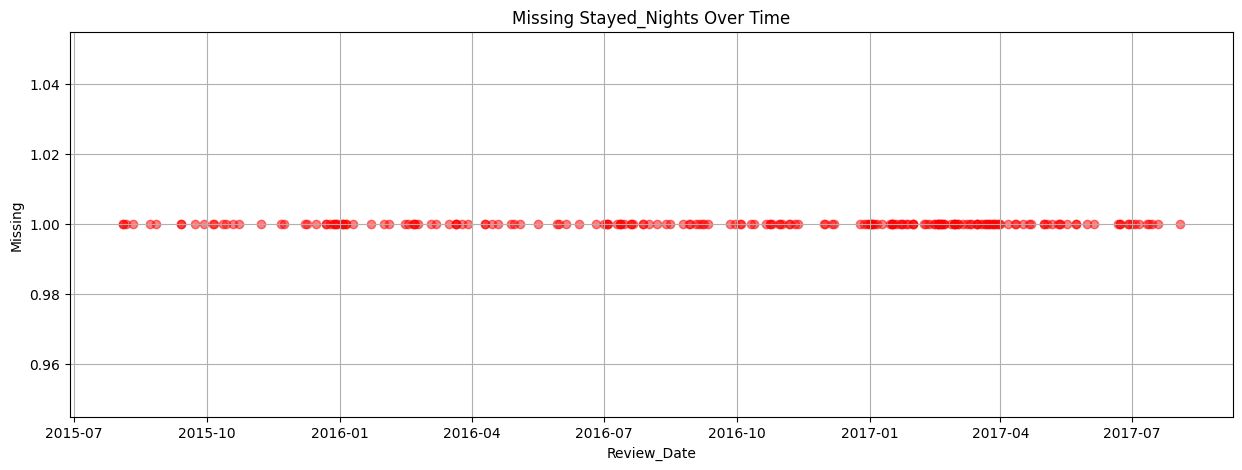

In [11]:
missing_only = temp[temp["Stayed_Nights"].isna()]
plt.figure(figsize=(15,5))
plt.scatter(missing_only.index, [1]*len(missing_only), color="r", marker="o",alpha=0.5)
plt.title("Missing Stayed_Nights Over Time")
plt.xlabel("Review_Date")
plt.ylabel("Missing")
plt.grid(True)
plt.show()

In [12]:
data["Stayed_Nights"] = data["Stayed_Nights"].fillna(data["Stayed_Nights"].mean())
data.drop_duplicates(inplace=True)


In [13]:
print(data.isna().sum())
print(data.duplicated().sum())

Additional_Number_of_Scoring                  0
Review_Date                                   0
Average_Score                                 0
Hotel_Name                                    0
Reviewer_Nationality                          0
Total_Number_of_Reviews                       0
Total_Number_of_Reviews_Reviewer_Has_Given    0
Reviewer_Score                                0
Days_Since_Review                             0
Review                                        0
Trip_Type                                     0
Group                                         0
Stayed_Nights                                 0
dtype: int64
0
